In [34]:
from datetime import datetime, timedelta, date

%pip install lunardate
from lunardate import LunarDate

%pip install numpy pandas requests
import pandas as pd

%pip install openmeteo_requests requests-cache retry-requests
import openmeteo_requests
import requests_cache
from retry_requests import retry

%pip install scikit-learn == 1.6.0 # in order to use with PythonAnywhere
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

%pip install prophet
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

%pip install joblib
import joblib
import os


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
zsh:1: = not found
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new rele

# Data Preparation

## Acquire raw data
1. Understand the raw data provided by Evergreen Farmers Market management team

In [35]:
DATAFILE_NAME = 'attendance_8am_1pm_20_min_interval.csv'

attendance_raw_data = pd.read_csv(DATAFILE_NAME)
print(f"Row count: {attendance_raw_data.shape[0]}")

Row count: 101


In [36]:
RAW_DATE_COL = 0
RAW_ATTENDANCE_COL_START = 1
RAW_ATTENDANCE_COL_END  = 14

attendance_raw_data.tail()

,"May 6, 2023",30,65,90,140,199,170,187,251,248,290,299,284,279,217
96,"Mar 15, 2025",0,0,0,123,225,225.0,257,315,282,363,327,240,284,206
97,"Mar 22, 2025",0,0,0,219,228,247.0,222,234,328,401,351,325,315,252
98,"Mar 29, 2025",0,0,0,125,179,189.0,183,210,242,195,305,285,240,216
99,"Apr 5, 2025",0,0,0,163,158,200.0,297,250,233,270,292,269,245,181
100,"Apr 12, 2025",0,0,0,238,242,251.0,235,239,215,254,281,290,21,301


This dataset consists of date (Saturdays), number of customer visits recorded at 20-minute interval, from 8AM to 1PM

## Data Cleaning
Fill missing values with the average of their adjacent (previous and next) non-nil values

In [37]:
def nan_count_in(df):
   return df.isna().sum().sum()

def fill_with_adjacent_avg(series):
    series = series.copy()
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]) and not pd.isna(series[i - 1]) and not pd.isna(series[i + 1]):
            series[i] = (series[i - 1] + series[i + 1]) / 2
    return series

print(f"NaN count before filling: {nan_count_in(attendance_raw_data)}")

for col in attendance_raw_data.columns[RAW_ATTENDANCE_COL_START:RAW_ATTENDANCE_COL_END + 1]:
    while attendance_raw_data[col].isna().any():
        prev = attendance_raw_data[col].copy()
        attendance_raw_data[col] = fill_with_adjacent_avg(attendance_raw_data[col])
        if attendance_raw_data[col].equals(prev):
            break

print(f"NaN count after filling: {nan_count_in(attendance_raw_data)}")


NaN count before filling: 1
NaN count after filling: 0


# Feature Engineering

In [38]:
DATE_COL = "ds"
ATTENDANCE_COL = "y"

dataset = pd.DataFrame({DATE_COL: attendance_raw_data[attendance_raw_data.columns[0]]})
dataset[DATE_COL] = pd.to_datetime(dataset[DATE_COL], format="%b %d, %Y")

dataset[ATTENDANCE_COL] = attendance_raw_data[attendance_raw_data.columns[RAW_ATTENDANCE_COL_START:RAW_ATTENDANCE_COL_END + 1]].sum(axis=1)
dataset[ATTENDANCE_COL] = dataset[ATTENDANCE_COL].astype(int)

dataset.head()

,ds,y
0,2023-05-13,3345
1,2023-05-20,2041
2,2023-05-27,2156
3,2023-06-03,3227
4,2023-06-10,2949


In [39]:
dataset.describe()

,ds,y
count,101,101.000000
mean,2024-04-27 00:00:00,3276.891089
min,2023-05-13 00:00:00,1553.000000
25%,2023-11-04 00:00:00,2461.000000
50%,2024-04-27 00:00:00,3227.000000
75%,2024-10-19 00:00:00,3978.000000
max,2025-04-12 00:00:00,6154.000000
std,NaN,1041.144177


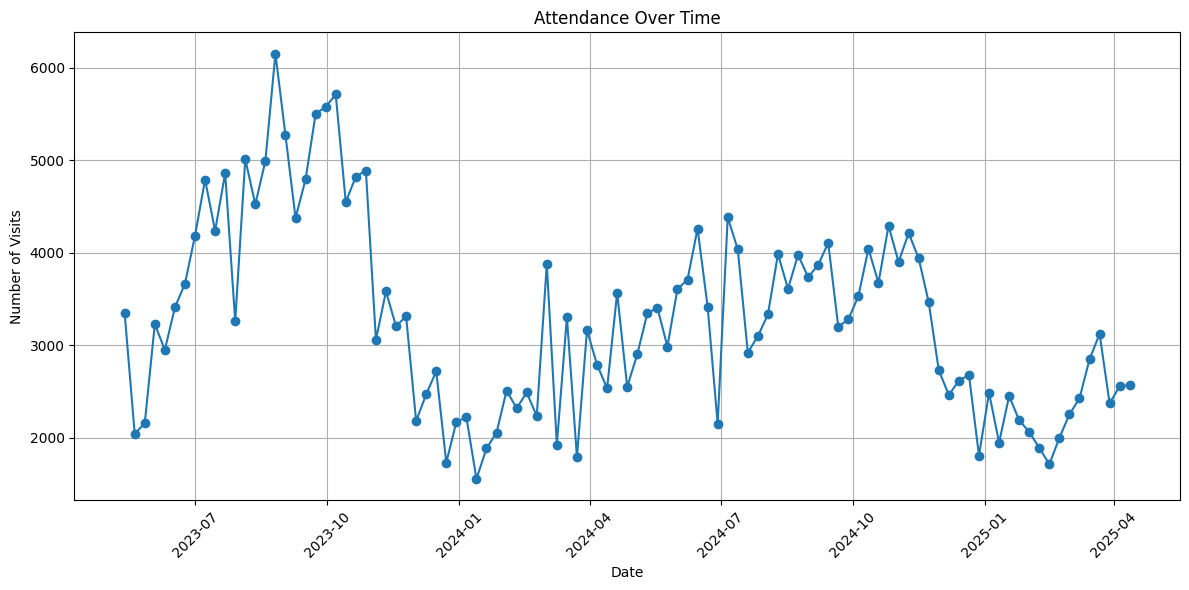

In [40]:
# plot line chart for visits over time
plt.figure(figsize=(12, 6))
plt.plot(dataset[DATE_COL], dataset[ATTENDANCE_COL], marker='o', linestyle='-')
plt.title("Attendance Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Visits")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


This dataset shows some seasonality trends - the visit count dips in Jan and then recovers and cap out during summer time.
The higher volume in 2023 could be due to the revenge buying phenonmenon that took place after the covid restriction were relaxed (On May 9, 2022, Mayor John Tory announced the termination of Toronto's COVID-19 state of emergency).

### Temporal Features


In [41]:
START_DATE = min(dataset[DATE_COL])
END_DATE = max(dataset[DATE_COL])
year_range = range(START_DATE.year, END_DATE.year + 1)

holiday_dates_df = make_holidays_df(
    year_list=year_range, country='CA', province='ON'
)

holiday_dates_list = []
holiday_list = []
for year in year_range:
    holiday_dates_list.append(datetime(year, 2, 14))
    holiday_list.append("Valentine's Day")

    holiday_dates_list.append(datetime(year, 5, 1) + timedelta(days=(6 - datetime(year, 5, 1).weekday()) % 7 + 7))
    holiday_list.append("Mother's Day")
    
    holiday_dates_list.append(datetime(year, 6, 1) + timedelta(days=(6 - datetime(year, 6, 1).weekday()) % 7 + 14))
    holiday_list.append("Father's Day")

    holiday_dates_list.append(datetime(year, 10, 31))
    holiday_list.append("Halloween")

    lunar_new_year = LunarDate(year, 1, 1).toSolarDate()
    holiday_dates_list.append(datetime(lunar_new_year.year, lunar_new_year.month, lunar_new_year.day))
    holiday_list.append("Lunar New Year")

    holiday_dates_list.append(datetime(year, 3, 17))
    holiday_list.append("St. Patrick's Day")

holiday_dates_df = pd.concat([holiday_dates_df, pd.DataFrame({
    DATE_COL: holiday_dates_list,
    "holiday": holiday_list
})], ignore_index=True)

# holiday_dates_df.head(n=10)

# TODO: tweak prior_scale for each holidays 

def is_holiday(date):
    return date in holiday_dates_df[DATE_COL].values or \
           date + timedelta(days=1) in holiday_dates_df[DATE_COL].values or \
           date + timedelta(days=2) in holiday_dates_df[DATE_COL].values or \
           date - timedelta(days=1) in holiday_dates_df[DATE_COL].values or \
           date - timedelta(days=2) in holiday_dates_df[DATE_COL].values

for i, row in dataset.iterrows():
	dataset.at[i, 'is_holiday'] = float(is_holiday(row[DATE_COL]))
      
dataset.head(n=10)

,ds,y,is_holiday
0,2023-05-13,3345,1.0
1,2023-05-20,2041,1.0
2,2023-05-27,2156,0.0
3,2023-06-03,3227,0.0
4,2023-06-10,2949,0.0
5,2023-06-17,3409,1.0
6,2023-06-24,3664,0.0
7,2023-07-01,4184,1.0
8,2023-07-08,4790,0.0
9,2023-07-15,4237,0.0


### Lag Features
For capturing trends.

* Visits_last_week
* Visits_two_weeks_ago


In [42]:
# Add column for visits from last week
dataset['visits_last_week'] = dataset[ATTENDANCE_COL].shift(1)
dataset['visits_last_week'] = dataset['visits_last_week'].fillna(0)

dataset['visits_two_weeks_ago'] = dataset[ATTENDANCE_COL].shift(2)
dataset['visits_two_weeks_ago'] = dataset['visits_two_weeks_ago'].fillna(0)

dataset.head()

,ds,y,is_holiday,visits_last_week,visits_two_weeks_ago
0,2023-05-13,3345,1.0,0.0,0.0
1,2023-05-20,2041,1.0,3345.0,0.0
2,2023-05-27,2156,0.0,2041.0,3345.0
3,2023-06-03,3227,0.0,2156.0,2041.0
4,2023-06-10,2949,0.0,3227.0,2156.0


### Weather Features

In [43]:
# Evergreem market coorindates
LAT = '43.6843353'
LONG = '-79.367293'

def date_string_from(date):
    return date.strftime("%Y-%m-%d")

def date_from(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

# WMO weather codes
# https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM
def is_sunny(weather_code):
    return weather_code <= 1

def is_cloudy(weather_code):
    return (weather_code >= 2 and weather_code <= 3) or (weather_code >= 45 and weather_code <= 48)

def is_rainy(weather_code):
    return (weather_code >= 51 and weather_code <= 67) or (weather_code >= 80 and weather_code <= 82) or (weather_code >= 95 and weather_code <= 99)

def is_snowy(weather_code):
    return (weather_code >= 71 and weather_code <= 77) or (weather_code >= 85 and weather_code <= 85)

# https://open-meteo.com/en/docs/historical-weather-api?daily=weather_code,temperature_2m_min,temperature_2m_max&timezone=America%2FNew_York
def fetch_weather_data():
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)

	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": LAT,
		"longitude": LONG,
		"start_date": date_string_from(START_DATE),
		"end_date": date_string_from(END_DATE),
		"daily": ["weather_code", "temperature_2m_min", "temperature_2m_max"],
		"timezone": "America/New_York"
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_weather_code = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
	daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
		start = date_string_from(pd.to_datetime(daily.Time(), unit = "s", utc = True)),
		end = date_string_from(pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True)),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
	)}

	daily_data["weather_code"] = daily_weather_code
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["temperature_2m_max"] = daily_temperature_2m_max

	return pd.DataFrame(data = daily_data)

weather_data = fetch_weather_data()

# Populate weather data in attendance dataset
for i, row in dataset.iterrows():
	weather_daily = weather_data.loc[weather_data["date"] == row[DATE_COL]]
	dataset.at[i, 'min_temp'] = float(weather_daily['temperature_2m_min'].iloc[0])
	dataset.at[i, 'max_temp'] = float(weather_daily['temperature_2m_max'].iloc[0])
     
	weather_code = weather_daily['weather_code'].iloc[0]
	dataset.at[i, 'is_sunny'] = int(is_sunny(weather_code))
	dataset.at[i, 'is_cloudy'] = int(is_cloudy(weather_code))
	dataset.at[i, 'is_rainy'] = int(is_rainy(weather_code))
	dataset.at[i, 'is_snowy'] = int(is_snowy(weather_code))

dataset.head()

Coordinates 43.6906852722168°N -79.4117431640625°E
Elevation 110.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s


,ds,y,is_holiday,visits_last_week,visits_two_weeks_ago,min_temp,max_temp,is_sunny,is_cloudy,is_rainy,is_snowy
0,2023-05-13,3345,1.0,0.0,0.0,12.908501,20.858500,0.0,1.0,0.0,0.0
1,2023-05-20,2041,1.0,3345.0,0.0,11.208500,18.658501,0.0,0.0,1.0,0.0
2,2023-05-27,2156,0.0,2041.0,3345.0,8.508500,21.008501,0.0,1.0,0.0,0.0
3,2023-06-03,3227,0.0,2156.0,2041.0,14.958500,22.608500,0.0,1.0,0.0,0.0
4,2023-06-10,2949,0.0,3227.0,2156.0,11.558500,25.258501,0.0,1.0,0.0,0.0


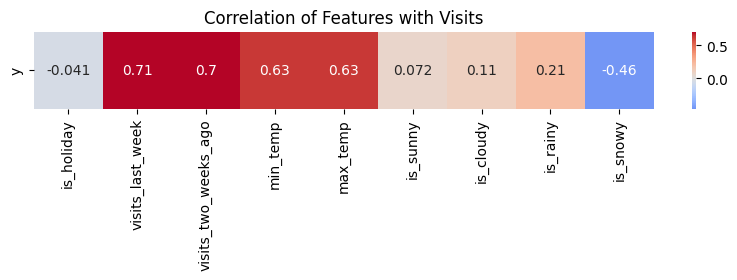

In [44]:
correlations = dataset.corr(numeric_only=True)['y'].drop('y')  # Drop correlation of y with itself

# Convert to DataFrame for heatmap
corr_df = correlations.to_frame().T  # Transpose for better heatmap display

# Plot heatmap
plt.figure(figsize=(10, 1))  # Short height for 1-row heatmap
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Features with Visits")
plt.show()

# Prophet training

In [45]:
# feature scaling: visits_last_week, visits_two_weeks_ago, min_temp, max_temp
scaler = StandardScaler()
dataset[['visits_last_week', 'visits_two_weeks_ago', 'min_temp', 'max_temp']] = scaler.fit_transform(
    dataset[['visits_last_week', 'visits_two_weeks_ago', 'min_temp', 'max_temp']]
)

dataset.tail()

,ds,y,is_holiday,visits_last_week,visits_two_weeks_ago,min_temp,max_temp,is_sunny,is_cloudy,is_rainy,is_snowy
96,2025-03-15,2847,1.0,-0.762797,-0.864216,0.018098,-0.011387,0.0,0.0,1.0,0.0
97,2025-03-22,3122,0.0,-0.373311,-0.710010,-1.043800,-0.686409,0.0,0.0,1.0,0.0
98,2025-03-29,2369,0.0,-0.119499,-0.336017,-0.594738,-1.101423,0.0,0.0,1.0,0.0
99,2025-04-05,2558,0.0,-0.814482,-0.092301,-0.235489,-0.116390,0.0,0.0,1.0,0.0
100,2025-04-12,2567,0.0,-0.640044,-0.759639,-0.436246,-0.456401,0.0,0.0,1.0,0.0


In [46]:

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)

# Create and fit the Prophet model
model = Prophet(
    yearly_seasonality=True, 
    holidays=holiday_dates_df)
model.add_regressor('visits_last_week')
model.add_regressor('visits_two_weeks_ago')
model.add_regressor('is_holiday')
model.add_regressor('min_temp')
model.add_regressor('max_temp')
model.add_regressor('is_sunny')
model.add_regressor('is_cloudy')
model.add_regressor('is_rainy')
model.add_regressor('is_snowy')

model.fit(dataset)

17:12:03 - cmdstanpy - INFO - Chain [1] start processing
17:12:03 - cmdstanpy - INFO - Chain [1] done processing


# Evaluation

In [47]:
# Evaluate the model with the test data
future = test_data[['ds']].copy()
future[['visits_last_week', 'visits_two_weeks_ago', 'is_holiday', 'min_temp', 'max_temp', 'is_sunny', 'is_cloudy', 'is_rainy', 'is_snowy']] = dataset[['visits_last_week', 'visits_two_weeks_ago', 'is_holiday', 'min_temp', 'max_temp', 'is_sunny', 'is_cloudy', 'is_rainy', 'is_snowy']]
forecast = model.predict(future)

# Merge actuals with predictions
results = test_data[['ds', 'y']].merge(
    forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)

mae = mean_absolute_error(results['y'], results['yhat'])
rmse = root_mean_squared_error(results['y'], results['yhat'])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 207.80
RMSE: 277.52


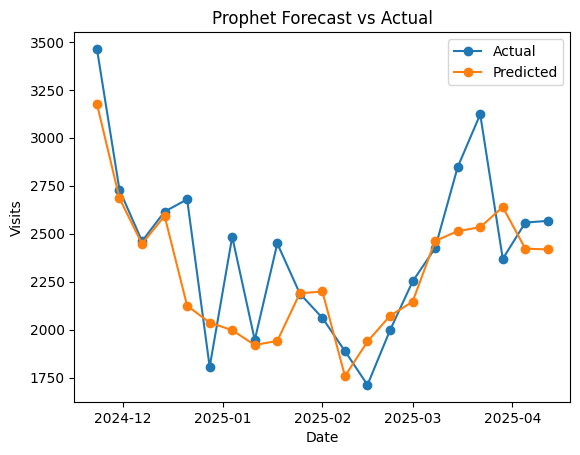

In [48]:
# Plot actual vs. predicted values
plt.plot(results['ds'], results['y'], label='Actual', marker='o')
plt.plot(results['ds'], results['yhat'], label='Predicted', marker='o')
plt.legend()
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.show()


# Save model

In [49]:
OUTPUT_DIR = 'output'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

joblib.dump(model, f'{OUTPUT_DIR}/attendance_model.pkl')
joblib.dump(scaler, f'{OUTPUT_DIR}/attendance_scaler.pkl')

['output/attendance_scaler.pkl']

# Prediction

In [54]:
OUTPUT_DIR = 'output'

model = joblib.load(f'{OUTPUT_DIR}/attendance_model.pkl')
scaler = joblib.load(f'{OUTPUT_DIR}/attendance_scaler.pkl')

future_date = date(2025, 4, 19)
is_holiday = False
visits_last_week = 2558
visits_two_weeks_ago = 2567
min_temp = 5.0
max_temp = 9.0

# Constructs the future input data
future_data = {
    "ds": [future_date],
    "is_holiday": [int(is_holiday)],
    "visits_last_week": [visits_last_week], 
    "visits_two_weeks_ago": [visits_two_weeks_ago],  
    'min_temp': [min_temp],
	'max_temp': [max_temp],
	'is_sunny': [int(False)],
	'is_cloudy': [int(True)],
	'is_rainy': [int(False)],
	'is_snowy': [int(False)],
}

# Creates dataFrame and scales it
future_df = pd.DataFrame(future_data)
future_df[['visits_last_week', 'visits_two_weeks_ago', 'min_temp', 'max_temp']] = scaler.transform(future_df[['visits_last_week', 'visits_two_weeks_ago', 'min_temp', 'max_temp']])

future_df.head()


,ds,is_holiday,visits_last_week,visits_two_weeks_ago,min_temp,max_temp,is_sunny,is_cloudy,is_rainy,is_snowy
0,2025-04-19,0,-0.640044,-0.584164,-0.077895,-0.432251,0,1,0,0


In [55]:
pred = model.predict(future_df)
pred["yhat"]

0    2977.478383
Name: yhat, dtype: float64